Text(0, 0.5, 'true positive rate')

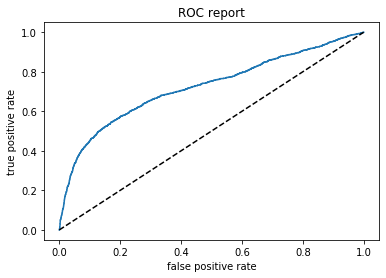

In [30]:
# author: Elliott Ribner
# date: 2020-01-20

# Jupyter version

'''This script fits a model and outputs several images and csv reports

Usage: src/analysis.py --input=<input> --output=<output>

Options:
--input=<input>  Name of csv file to download, must be within the /data directory.
--output=<output>  Name of directory to be saved in, no slashes nesscesary, 'results' folder recommended. 
'''

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from docopt import docopt

# turn csv to dataframe
df = pd.read_csv("data/cleaned-credit-default-data.csv", index_col=0)

# split training and test
X = df.drop(columns=['DEFAULT_NEXT_MONTH'])
y = df['DEFAULT_NEXT_MONTH']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=122)

# We use robust scalar as most of our data is not normally distributed and we have a high amount of outliers.
columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
           'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
           'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
           'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
scaler = preprocessing.RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=columns)

# Use RFE to identify the most identify the most useful predictors.
# Then we will drop those columns that are deemed as less useful.
logreg = LogisticRegression(solver="lbfgs")
rfe = RFE(logreg, 14)
rfe = rfe.fit(X_train, y_train.values.ravel())
columns_to_drop = list()
for i in range(len(rfe.support_)):
    include = rfe.support_[i]
    if include == False:
        columns_to_drop.append(columns[i])
X_train = X_train.drop(columns_to_drop, axis=1)
X_test = X_test.drop(columns_to_drop, axis=1)

os = SMOTE(random_state=0)
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)

# tune hyper parameters and fit model
hyperparameters = {
    'C': np.logspace(-4, 4, 20)
}
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(os_data_X, os_data_y)

# measure accuracies
train_predictions = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
accuracies_df = pd.DataFrame(index=['test accuracy', 'train accuracy', 'test recall', 'test precision', 'auc score'], data={
    'result': [test_accuracy, train_accuracy, test_recall, test_precision, auc_score]
})
accuracies_df

# plot and report confusion matrix
plot_confusion_matrix(best_model, X_test, y_test)
report = classification_report(y_test, test_predictions, output_dict=True)
report_df = pd.DataFrame(report)
report_df
plt.savefig('results/confusion_matrix.png')
plt.clf()

# compute and save roc curve
fpr, tpr, thresholds = roc_curve(
    y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC report')
plt.plot((0, 1), (0, 1), '--k')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')


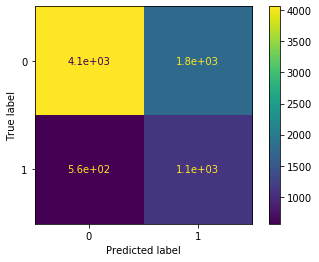

In [31]:
plot_confusion_matrix(best_model, X_test, y_test)


In [22]:
accuracies_df

,result
test accuracy,0.687200
train accuracy,0.684844
test recall,0.658610
test precision,0.379659
auc score,0.723004
